In [1]:
__author__ = 'Chien-Hsiu Lee <chien-hsiu.lee@noirlab.edu> and Thomas Matheson <tom.matheson@noirlab.edu>'
__version__ = '20211130' # yyyymmdd
__datasets__ = ['']
__keywords__ = ['ANTARES', 'movingobject']

# Exploring Elastic Search Database to Investigate Moving Object Lightcurves

*Chien-Hsiu Lee, Thomas Matheson & ANTARES Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [First chapter](#chapter1)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
This notebook is an example of how to explore the ANTARES alert database for moving objects. ZTF searches moving object database (JPL/HORIZON) and associates alerts to known moving objects. This piece of information is stored in the ANTARES alert database, so we can conveniently use the moving object information in the alerts to extract light curves.

# Summary

Moving objects may undergo abrupt brightnes change due to outgassing activities or disintegration, which can be identified in their light curves. There is also a group of binary asteroids that manifest periodic brightness change.

As a showcase, we obtain the light curve of 809 Lundia, a known binary asteroids with prominent eclipses. We then remove the long-term trend in the light curve and fold with its period to reveal the binary eclipses.

# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
from antares_client.search import search
import matplotlib.pyplot as plt
import pandas as pd

<a class="anchor" id="import"></a>
# Querying ANTARES alert database 

This cell shows how to call elastic search with ANTARES API. It can search on ZTF object id, RA, Dec, or other properties. For our purpose, we search for ZTF alerts associated with 809 Lundia using the keyword ztf_ssnamenr. 

In [3]:
query = {
        "query": {
            "bool": {
                "must": [
                    {
                        "match": {
                            "properties.ztf_ssnamenr": 809
                        }
                    },
                    
                 ]
            }
        }
    }
result_set = search(query)



<a class="anchor" id="import"></a>
# Extracting light curve related properties

Now the query is finished, let's extract relevant properties (MJD, Mag, Mag_err) for this moving object.

In [4]:
gmjd = []
gmag = []
gerr = []
rmjd = []
rmag = []
rerr = []
for locus in search(query):
    for alert in locus.alerts:
        if 'ztf_ssnamenr' in alert.properties:
            if alert.properties['ant_passband'] == 'R':                
                rmjd.append(alert.properties['ztf_jd'])
                rmag.append(alert.properties['ant_mag'])
                rerr.append(alert.properties['ant_magerr'])
            if alert.properties['ant_passband'] == 'g':                
                gmjd.append(alert.properties['ztf_jd'])
                gmag.append(alert.properties['ant_mag'])
                gerr.append(alert.properties['ant_magerr'])


Having the time-series photometry in hand, we can plot the light curve.

<function matplotlib.pyplot.show(close=None, block=None)>

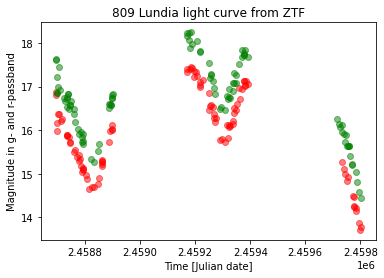

In [5]:
plt.scatter(rmjd, rmag, c='red', alpha=0.5)
plt.scatter(gmjd, gmag, c='green', alpha=0.5)
plt.title('809 Lundia light curve from ZTF')
plt.xlabel('Time [Julian date]')
plt.ylabel('Magnitude in g- and r-passband')
plt.show

Now we want to see if we can find the binary eclipses in the light curves. First we need to remove the long-term trend. This can be done by comparing with the apparent magnitude predicted by JPL/HORIZONS. It has been shown that Lundia has a period of 15.42 hours, we also fold the light curve with this period after de-trending.

In [6]:
from scipy import interpolate
#we read in the predictions of the brightness (according to the distance to the sun) from JPL/HORIZONS
lc = pd.read_csv('JPL809.csv')
jpl_jd = lc['JD']
jpl_mag = lc['Vmag']
period=15.42/24.
x0=[]
y0=[]
for i in range(len(jpl_jd)):
    x0.append(float(jpl_jd[i]))
    y0.append(float(jpl_mag[i]))

def ref_mag(x):
    tck0 = interpolate.splrep(x0, y0)
    return interpolate.splev(x,tck0)

mgdate=[]
mrdate=[]
mrmag=[]
mgmag=[]

for i in range(len(rmjd)):
    mrdate.append((float(rmjd[i])%period)/period)
    mrmag.append(float(rmag[i])-ref_mag(float(rmjd[i])))
for i in range(len(gmjd)):
    mgdate.append((float(gmjd[i])%period)/period)
    mgmag.append(float(gmag[i])-ref_mag(float(gmjd[i])))


We can now plot the de-trend and folded light curve.

<function matplotlib.pyplot.show(close=None, block=None)>

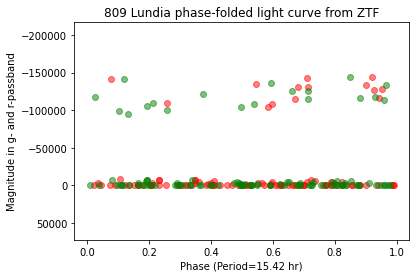

In [7]:
#plot folded light curve
plt.ylim(max(mgmag)+0.5*(max(mgmag)-min(mgmag)),min(mrmag)-0.5*(max(mrmag)-min(mrmag)))
plt.scatter(mrdate, mrmag, c='red', alpha=0.5)
plt.scatter(mgdate, mgmag, c='green', alpha=0.5)
plt.title('809 Lundia phase-folded light curve from ZTF')
plt.xlabel('Phase (Period=15.42 hr)')
plt.ylabel('Magnitude in g- and r-passband')

plt.show

# Concluding remarks

The ZTF folded light curve manifests trace of binary eclipses, consistent with previous study by Kryszcynska et al. (2009) that first revealed the binary nature of 809 Lundia. 
<img src="809LundiaPhasedLC.jpeg">

# Resources and references
Further reading:

Kryszcynska et al. (2009) "New binary asteroid 809 Lundia. I. Photometry and modelling". A&A, 501, 769:
https://ui.adsabs.harvard.edu/abs/2009A%26A...501..769K/abstract
